In [ ]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers rasterio shapely pyproj flask flask-ngrok flask-cors pyngrok
!ngrok update
!ngrok authtoken '' #put your token here

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 84.0 MB/s eta 0:00:00
INFO[03-22|14:44:22] no configuration paths supplied 
DBUG[03-22|14:44:22] ngrok config file at legacy location does not exist legacy_path=/root/.config/ngrok/ngrok.yml
INFO[03-22|14:44:22] using configuration at default config path path=/root/.config/ngrok/ngrok.yml
INFO[03-22|14:44:22] open config file                         path=/root/.config/ngrok/ngrok.yml err=nil
No update available, this is the latest version.
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


## Imports


In [2]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple
import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline
import json
import gc
import os
import rasterio
from rasterio.transform import xy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pyproj import Transformer

# Constants for high-quality export
HIGH_DPI_RESULT = 300  # Adjust DPI for result image (detailed visualization)
HIGH_DPI_POLYGON = 600  # Higher DPI for polygon visualization
SAVE_FORMAT_RESULT = "jpeg"  # Use JPEG for lossy but detailed image
SAVE_FORMAT_POLYGON = "png"  # Use PNG for lossless polygon export

@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))

def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

def random_named_css_colors(num_colors: int) -> List[str]:
    """
    Returns a list of randomly selected named CSS colors.

    Args:
    - num_colors (int): Number of random colors to generate.

    Returns:
    - list: List of randomly selected named CSS colors.
    """
    # List of named CSS colors
    named_css_colors = [
        'aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond',
        'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue',
        'cornsilk', 'crimson', 'cyan', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey',
        'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
        'darkslateblue', 'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue',
        'dimgray', 'dimgrey', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite',
        'gold', 'goldenrod', 'gray', 'green', 'greenyellow', 'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory',
        'khaki', 'lavender', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow',
        'lightgray', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray',
        'lightslategrey', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'linen', 'magenta', 'maroon', 'mediumaquamarine',
        'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise',
        'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'navy', 'oldlace', 'olive',
        'olivedrab', 'orange', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip',
        'peachpuff', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'rebeccapurple', 'red', 'rosybrown', 'royalblue', 'saddlebrown',
        'salmon', 'sandybrown', 'seagreen', 'seashell', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'slategrey',
        'snow', 'springgreen', 'steelblue', 'tan', 'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white',
        'whitesmoke', 'yellow', 'yellowgreen'
    ]

    # Sample random named CSS colors
    return random.sample(named_css_colors, min(num_colors, len(named_css_colors)))

def plot_detections_plotly(
    image: np.ndarray,
    detections: List[DetectionResult],
    class_colors: Optional[Dict[str, str]] = None
) -> None:
    # Define a fixed red color for bounding boxes and transparent blue for masks
    BBOX_COLOR = "red"
    MASK_COLOR = "rgba(0, 0, 255, 0.2)"  # Transparent blue

    # If class_colors is not provided, generate random colors for each class
    if class_colors is None:
        num_detections = len(detections)
        colors = random_named_css_colors(num_detections)
        class_colors = {}
        for i in range(num_detections):
            class_colors[i] = colors[i]

    fig = px.imshow(image)

    # Add bounding boxes and masks
    shapes = []
    annotations = []
    for idx, detection in enumerate(detections):
        label = detection.label
        box = detection.box
        score = detection.score
        mask = detection.mask

        # Create a polygon from the mask and add it as a transparent blue shape
        polygon = mask_to_polygon(mask)
        fig.add_trace(go.Scatter(
            x=[point[0] for point in polygon] + [polygon[0][0]],
            y=[point[1] for point in polygon] + [polygon[0][1]],
            mode='lines',
            line=dict(color="blue", width=0),
            fill='toself',
            fillcolor=MASK_COLOR,
            name=f"{label} Mask"
        ))

        # Add bounding box as a thick red rectangle
        xmin, ymin, xmax, ymax = box.xyxy
        shape = [
            dict(
                type="rect",
                xref="x", yref="y",
                x0=xmin, y0=ymin,
                x1=xmax, y1=ymax,
                line=dict(color=BBOX_COLOR, width=4)  # Red color with thicker stroke
            )
        ]
        annotation = [
            dict(
                x=(xmin + xmax) // 2, y=(ymin + ymax) // 2,
                xref="x", yref="y",
                text=f"{label}: {score:.2f}",
                showarrow=False,
                font=dict(color=BBOX_COLOR)
            )
        ]

        shapes.append(shape)
        annotations.append(annotation)

    # Update layout with buttons for toggling detections
    button_shapes = [dict(label="None", method="relayout", args=["shapes", []])]
    button_shapes = button_shapes + [
        dict(label=f"Detection {idx+1}", method="relayout", args=["shapes", shape]) for idx, shape in enumerate(shapes)
    ]
    button_shapes = button_shapes + [dict(label="All", method="relayout", args=["shapes", sum(shapes, [])])]

    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        showlegend=True,
        updatemenus=[
            dict(
                type="buttons",
                direction="up",
                buttons=button_shapes
            )
        ],
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Show plot
    fig.show()

def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections

# Constants
MAX_SIZE = 4096  # Maximum dimension before tiling (adjust based on GPU memory)
TILE_SIZE = 256  # Size of each tile for detection

def split_image_into_tiles(image, tile_size=TILE_SIZE):
    """
    Splits an image into smaller tiles if it's too large.

    :param image: NumPy array (H, W, C)
    :param tile_size: Size of each tile (square)
    :return: List of (tile, x_offset, y_offset)
    """
    img_h, img_w, _ = image.shape
    tiles = []

    for y in range(0, img_h, tile_size):
        for x in range(0, img_w, tile_size):
            # Ensure tiles don't go out of bounds
            tile = image[y:min(y + tile_size, img_h), x:min(x + tile_size, img_w)]
            tiles.append((tile, x, y))  # Store tile and offset

    return tiles

def ensure_rgb(image: np.ndarray) -> np.ndarray:
    """Converts grayscale/BGR image to RGB format expected by models."""
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[-1] == 4:  # RGBA (Remove alpha)
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    elif image.shape[-1] == 3:  # BGR (OpenCV default) to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def process_tiles(image, labels, threshold, detector_id, segmenter_id):
    image = np.array(Image.open(image)) if isinstance(image, str) else np.array(image)
    image = ensure_rgb(image)  # Convert to RGB

    if max(image.shape[:2]) > MAX_SIZE:
        print(f"Image too large ({image.shape}), splitting into tiles...")
        tiles = split_image_into_tiles(image, tile_size=TILE_SIZE)
    else:
        tiles = [(image, 0, 0)]  # Process as a single image if within size limit

    all_detections = []

    for i, (tile, x_offset, y_offset) in enumerate(tiles):
        print(f"Processing tile {i + 1}/{len(tiles)} at offset ({x_offset}, {y_offset})...")
        tile_image = Image.fromarray(tile)

        try:
            # Disable autograd to save memory
            with torch.no_grad():
                _, detections = grounded_segmentation(
                    image=tile_image,
                    labels=labels,
                    threshold=threshold,
                    detector_id=detector_id,
                    segmenter_id=segmenter_id
                )

            # Adjust bounding boxes and masks to original coordinates
            for detection in detections:
                detection.box.xmin += x_offset
                detection.box.xmax += x_offset
                detection.box.ymin += y_offset
                detection.box.ymax += y_offset

                if detection.mask is not None:
                    detection.mask = np.roll(detection.mask, shift=(y_offset, x_offset), axis=(0, 1))

                all_detections.append(detection)

        except torch.cuda.OutOfMemoryError:
            print("⚠️ CUDA Out of Memory! Skipping this tile...")

        finally:
            # Explicitly delete variables and clear GPU memory
            del tile, tile_image, detections
            torch.cuda.empty_cache()  # Clear CUDA cache
            gc.collect()             # Garbage collection
            torch.cuda.ipc_collect()  # Additional GPU memory cleanup

    return image, all_detections


# Function to create a blank canvas matching input image size
def create_white_canvas(image_shape):
    """Creates a blank white canvas of the same dimensions as the input image."""
    height, width = image_shape[:2]  # Get image dimensions (H, W)
    return np.ones((height, width, 3), dtype=np.uint8) * 255  # White background

# Function to plot and save polygon visualization with original image size
def plot_polygon_on_white_canvas(detections, image_shape):
    """
    Plots detected polygons on a white blank canvas with the same dimensions as input image.
    """
    canvas = create_white_canvas(image_shape)  # Ensure exact same size as input
    polygon_definitions = []

    for detection in detections:
        if detection.mask is not None:
            mask = detection.mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                # Get largest contour (most significant polygon)
                largest_contour = max(contours, key=cv2.contourArea)

                # Convert contour points to a list of tuples (X, Y)
                polygon = largest_contour.reshape(-1, 2).tolist()
                polygon_definitions.append(polygon)

                # Draw the contour (black lines)
                cv2.drawContours(canvas, [largest_contour], -1, (0, 0, 0), 2)

    return canvas, polygon_definitions

# Function to resize image by a percentage while maintaining aspect ratio
def resize_image(image: Union[np.ndarray, Image.Image], scale_percent: float) -> np.ndarray:
    """Resizes the image by a percentage of its original size while maintaining the original aspect ratio."""
    # OpenCV format (np.ndarray)
    if isinstance(image, np.ndarray):
        h, w = image.shape[:2]
    # PIL format (Image.Image)
    else:
        h, w = image.size

    # Calculate new dimensions based on the scale percentage
    new_w = int(w * scale_percent)
    new_h = int(h * scale_percent)

    # Resize the image
    resized_image = cv2.resize(image, (new_w, new_h))
    return resized_image

# Updated function using PIL instead of Matplotlib for high-quality JPEG export
def export_result_high_quality(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = "result_high_quality.jpeg"
) -> None:
    annotated_image = annotate(image, detections)  # Get annotated image as NumPy array

    # Convert NumPy array to PIL Image
    pil_image = Image.fromarray(annotated_image)

    # Save as JPEG with high quality
    pil_image.save(save_name, "JPEG", quality=95)  # Fix: Use PIL's quality setting
    print(f"Saved high-quality result as {save_name}")

# Function to save polygon visualization in high resolution
def export_polygon_visualization_high_quality(canvas, save_name="polygon_visualization_high_quality.png"):
    """Saves the polygon visualization at full resolution using PIL."""
    pil_image = Image.fromarray(canvas)  # Convert NumPy array to PIL Image
    pil_image.save(save_name, "PNG")  # Save as PNG (lossless)
    print(f"Saved high-quality polygon visualization as {save_name}")

# --------------------------- Step 1: Load JSON Polygons --------------------------- #
def load_polygons(json_path):
    """Loads polygon definitions from a JSON file."""
    with open(json_path, "r") as f:
        data = json.load(f)

    # Ensure data is in a valid list format
    if not isinstance(data, list):
        raise ValueError("Invalid JSON structure. Expected a list of polygons.")

    # Convert lists of coordinates to Shapely Polygon objects
    polygons = []
    for coords in data:
        if isinstance(coords, list) and all(isinstance(pt, list) and len(pt) == 2 for pt in coords):
            polygons.append(Polygon(coords))  # Convert to Polygon
        else:
            raise ValueError("Each polygon must be a list of [x, y] coordinate pairs.")

    return polygons


# --------------------------- Step 2: Simplify Polygons --------------------------- #
def simplify_polygons(polygons, tolerance=20.0):
    """Simplifies polygons using a given tolerance value."""
    smoothed_polygons = []

    for polygon in polygons:
        smoothed_polygon = polygon.simplify(tolerance, preserve_topology=True)
        coords_list = [[float(x), float(y)] for x, y in smoothed_polygon.exterior.coords]
        smoothed_polygons.append(coords_list)

    return smoothed_polygons


# --------------------------- Step 3: Save Simplified Polygons --------------------------- #
def save_json(data, output_path, description=""):
    """Saves data to a JSON file with indentation. Ensures directory exists before saving."""
    output_dir = os.path.dirname(output_path)  # Extract directory path

    # If output_dir is empty (means no subfolder needed), we skip creating it
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

    with open(output_path, "w") as f:
        json.dump(data, f, indent=4)

    print(f"{description} saved to {output_path}")


# --------------------------- Step 4: Plot Polygons --------------------------- #
def plot_polygons(polygons, title="Painted Areas of Smoothed Polygons"):
    """Plots and visualizes polygons before saving."""
    plt.figure(figsize=(12, 10))

    for i, polygon in enumerate(polygons):
        smoothed_coords = list(polygon.exterior.coords)
        x, y = zip(*smoothed_coords)
        plt.fill(x, y, alpha=0.5, label=f"Polygon {i+1}")

    plt.title(title)
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --------------------------- Step 5: Convert Pixel to Geo Coordinates --------------------------- #
def load_tif_metadata(tif_path):
    """Loads raster metadata including transform and CRS."""
    with rasterio.open(tif_path) as dataset:
        return dataset.transform, dataset.crs.to_string()


def pixel_to_geo(polygon, transform, transformer):
    """Converts pixel coordinates to real-world (lat, lon) coordinates."""
    projected_coords = [xy(transform, y, x) for x, y in polygon]  # Swap x, y
    return [[round(lat, 6), round(lon, 6)] for lon, lat in [transformer.transform(x, y) for x, y in projected_coords]]


def convert_polygons_to_geojson(polygons, transform, source_crs, output_dir="output"):
    """Converts polygons from pixel coordinates to geographic coordinates."""
    transformer = Transformer.from_crs(source_crs, "EPSG:4326", always_xy=True)
    geo_polygons = []

    for i, polygon in enumerate(polygons, start=1):
        converted_coords = pixel_to_geo(polygon, transform, transformer)
        geo_polygons.append({"polygonid": str(i), "coordinates": converted_coords})

    output_path = os.path.join(output_dir, "geo_polygon_definitions.json")
    save_json(geo_polygons, output_path, "Georeferenced polygons")


# --------------------------- Execution Pipeline --------------------------- #
def run_pipeline(json_input="polygon_definitions.json", tif_path="odm_orthophoto.tif", tolerance=20.0):
    """
    Executes the full pipeline:
    1. Load polygon JSON
    2. Simplify polygons
    3. Plot results
    4. Convert pixel coordinates to geographic coordinates
    """
    # Load and process polygons
    polygons = load_polygons(json_input)
    smoothed_polygons = simplify_polygons(polygons, tolerance)

    # Save smoothed polygons
    save_json(smoothed_polygons, "smoothed_polygons.json", "Smoothed polygons")

    # Plot smoothed polygons
    plot_polygons([Polygon(coords) for coords in smoothed_polygons])

    # Convert pixel coordinates to geographic coordinates
    transform, source_crs = load_tif_metadata(tif_path)
    convert_polygons_to_geojson(smoothed_polygons, transform, source_crs)

def process_image(image_path: str, labels: List[str] = ["building"], threshold: float = 0.2,
                   detector_id: str = "IDEA-Research/grounding-dino-tiny",
                   segmenter_id: str = "facebook/sam-vit-base",
                   scale_percent: float = 1.0):
    """
    Processes an image file for object detection, segmentation, and polygon extraction.

    Args:
        image_path (str): Path to the input image.
        labels (List[str]): List of labels for detection.
        threshold (float): Detection threshold.
        detector_id (str): Object detector model ID.
        segmenter_id (str): Segmenter model ID.
        scale_percent (float): Scale factor for resizing.

    Returns:
        str: Path to the dynamically generated geo-referenced polygon JSON file.
    """
    # Extract filename without extension
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    # Define output filenames dynamically
    result_json = f"output/{base_name}_geo_polygon_definitions.json"
    result_img = f"{base_name}_result_high_quality.jpeg"
    result_polygon = f"{base_name}_polygon_visualization_high_quality.png"
    polygon_json = f"{base_name}_polygon_definitions.json"

    # Ensure output directory exists
    os.makedirs("output", exist_ok=True)

    with torch.no_grad():
      torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.ipc_collect()

    # Clear CUDA cache
    torch.cuda.empty_cache()
    gc.collect()

    # Load and resize the image
    image = cv2.imread(image_path)
    resized_image = resize_image(image, scale_percent)
    pil_image = Image.fromarray(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

    # Disable gradient tracking for inference
    with torch.inference_mode():
        image_array, detections = grounded_segmentation(
            image=pil_image,
            labels=labels,
            threshold=threshold,
            polygon_refinement=True,
            detector_id=detector_id,
            segmenter_id=segmenter_id
        )

    with torch.no_grad():
      torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.ipc_collect()

    # Generate polygon visualization
    canvas, polygon_definitions = plot_polygon_on_white_canvas(detections, image_array.shape)

    # Save results
    with open(polygon_json, "w") as f:
        json.dump(polygon_definitions, f, indent=4)

    export_result_high_quality(image_array, detections, result_img)
    export_polygon_visualization_high_quality(canvas, result_polygon)

    # Process polygon conversion
    run_pipeline(json_input=polygon_json, tif_path=image_path, tolerance=20.0)

    # Rename final output JSON file
    final_geojson_path = f"output/{base_name}_geo_polygon_definitions.json"
    os.rename("output/geo_polygon_definitions.json", final_geojson_path)

    with torch.no_grad():
      torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.ipc_collect()

    # Return dynamically generated file path
    return final_geojson_path

# choose an image

In [3]:
from pyngrok import ngrok

# Start an HTTP tunnel on port 5000
public_url = ngrok.connect(5000, "http")

print(f"Ngrok tunnel open at: {public_url}")


Ngrok tunnel open at: NgrokTunnel: "https://23b7-34-143-142-138.ngrok-free.app" -> "http://localhost:5000"


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:45:43] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:45:44] "GET /favicon.ico HTTP/1.1" 404 -


[TASK 1733ec4e-0ac0-4182-b803-5fa55c2d5916] Processing started...


INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:31] "POST /upload HTTP/1.1" 202 -
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:31] "POST /upload HTTP/1.1" 202 -


[TASK eae7349d-b6a0-497f-b9f5-083471bdb334] Processing started...


INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:32] "GET /status/1733ec4e-0ac0-4182-b803-5fa55c2d5916 HTTP/1.1" 200 -
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:32] "GET /status/eae7349d-b6a0-497f-b9f5-083471bdb334 HTTP/1.1" 200 -


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:37] "GET /status/1733ec4e-0ac0-4182-b803-5fa55c2d5916 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:38] "GET /status/eae7349d-b6a0-497f-b9f5-083471bdb334 HTTP/1.1" 200 -


tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:43] "GET /status/1733ec4e-0ac0-4182-b803-5fa55c2d5916 HTTP/1.1" 200 -


added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:44] "GET /status/eae7349d-b6a0-497f-b9f5-083471bdb334 HTTP/1.1" 200 -


preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda
Device set to use cuda
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:49] "GET /status/1733ec4e-0ac0-4182-b803-5fa55c2d5916 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:50] "GET /status/eae7349d-b6a0-497f-b9f5-083471bdb334 HTTP/1.1" 200 -


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:55] "GET /status/1733ec4e-0ac0-4182-b803-5fa55c2d5916 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:46:55] "GET /status/eae7349d-b6a0-497f-b9f5-083471bdb334 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:47:00] "GET /status/1733ec4e-0ac0-4182-b803-5fa55c2d5916 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:47:01] "GET /status/eae7349d-b6a0-497f-b9f5-083471bdb334 HTTP/1.1" 200 -


Saved high-quality result as 1733ec4e-0ac0-4182-b803-5fa55c2d5916_result_high_quality.jpeg
Saved high-quality polygon visualization as 1733ec4e-0ac0-4182-b803-5fa55c2d5916_polygon_visualization_high_quality.png
Saved high-quality result as eae7349d-b6a0-497f-b9f5-083471bdb334_result_high_quality.jpeg
Smoothed polygons saved to smoothed_polygons.json


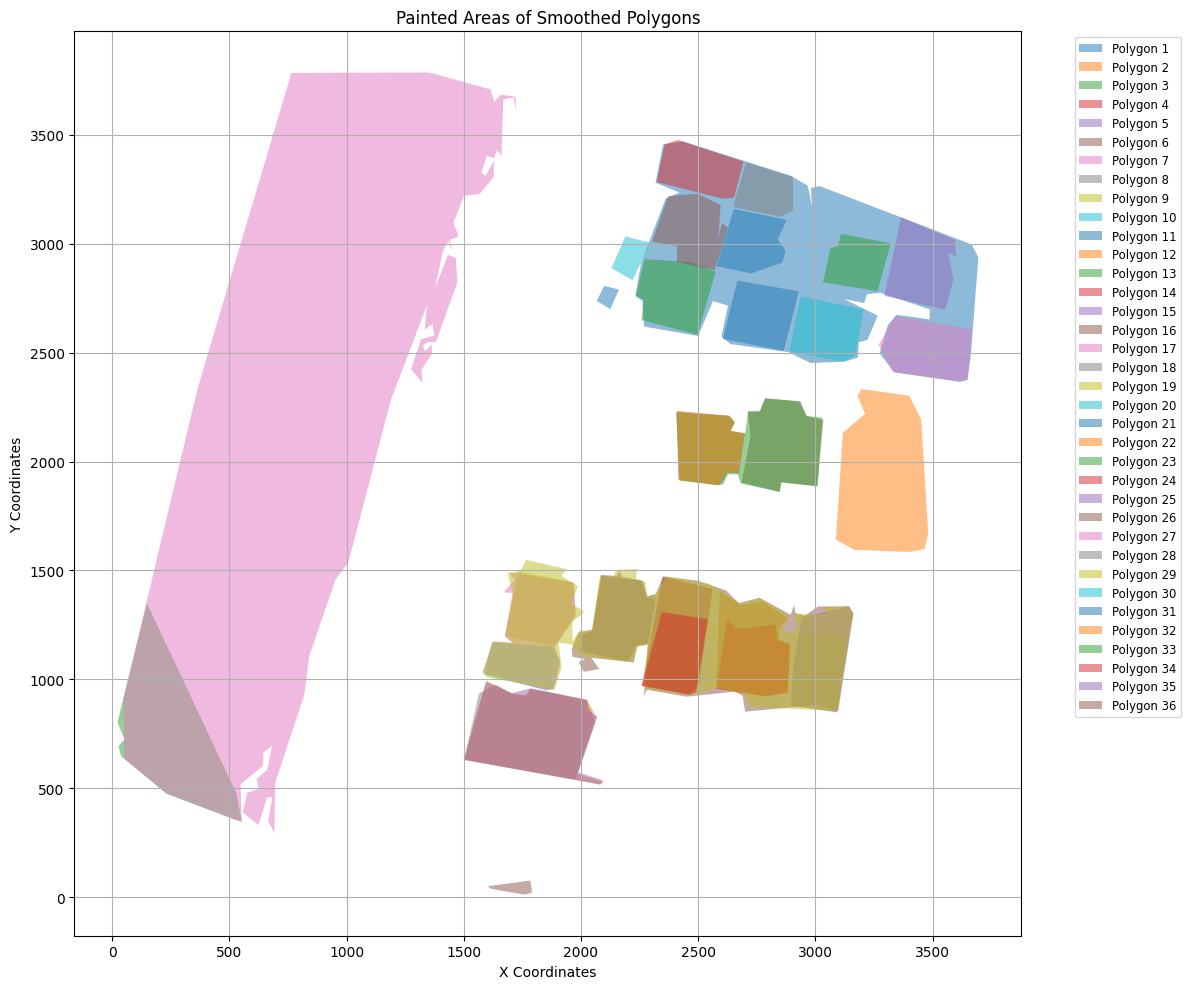

Georeferenced polygons saved to output/geo_polygon_definitions.json
[TASK 1733ec4e-0ac0-4182-b803-5fa55c2d5916] Processing complete. Output saved to results/1733ec4e-0ac0-4182-b803-5fa55c2d5916.json
Saved high-quality polygon visualization as eae7349d-b6a0-497f-b9f5-083471bdb334_polygon_visualization_high_quality.png
Smoothed polygons saved to smoothed_polygons.json


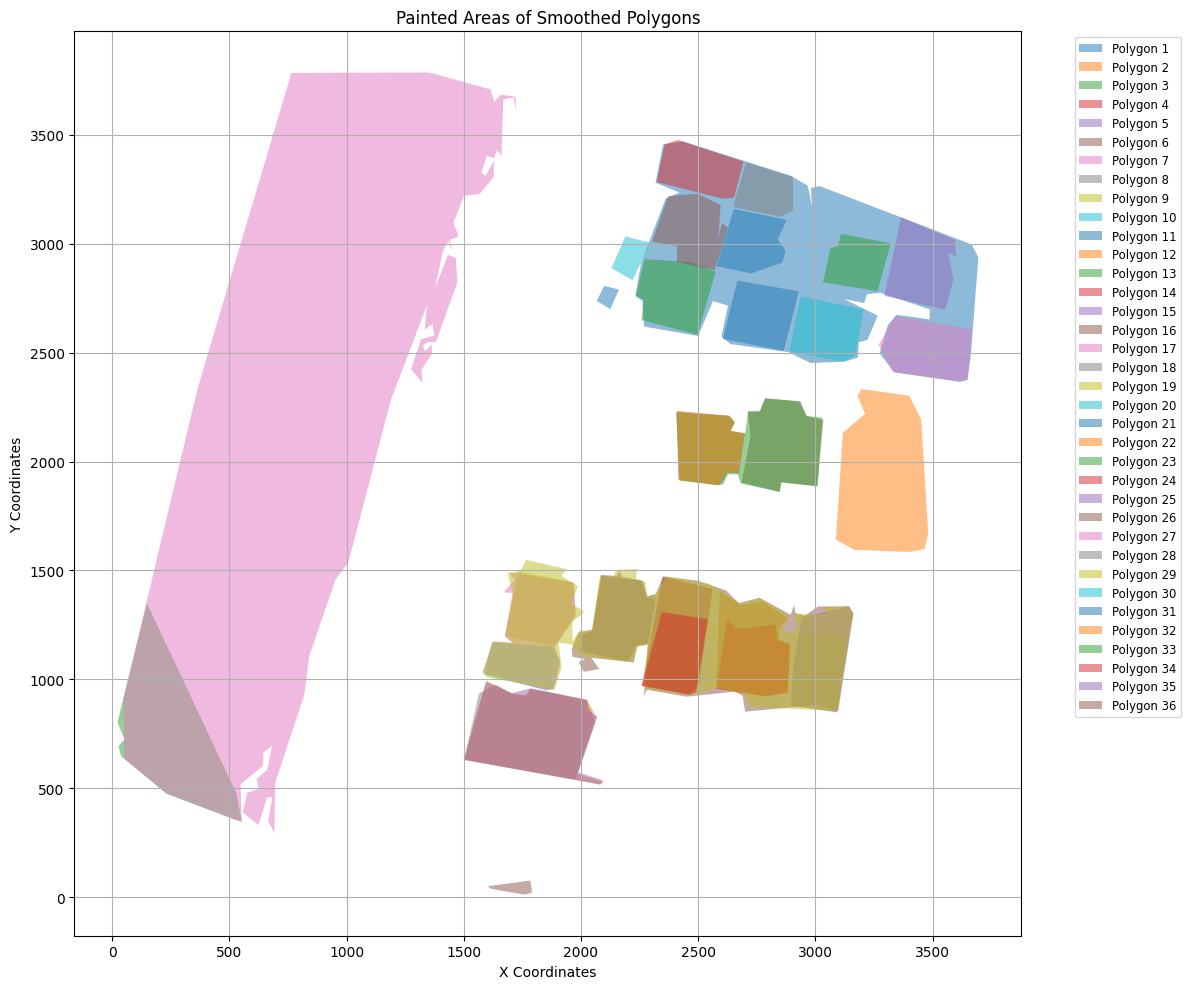

Georeferenced polygons saved to output/geo_polygon_definitions.json
[TASK eae7349d-b6a0-497f-b9f5-083471bdb334] Processing complete. Output saved to results/eae7349d-b6a0-497f-b9f5-083471bdb334.json


INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:47:06] "GET /status/1733ec4e-0ac0-4182-b803-5fa55c2d5916 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [22/Mar/2025 14:47:07] "GET /status/eae7349d-b6a0-497f-b9f5-083471bdb334 HTTP/1.1" 200 -


In [ ]:
from flask import Flask, request, jsonify
import os
import time
import threading
import uuid
import json
from werkzeug.utils import secure_filename

app = Flask(__name__)

# Allow large file uploads (50MB)
app.config['MAX_CONTENT_LENGTH'] = 50 * 1024 * 1024

# Directories
UPLOAD_FOLDER = "uploads"
RESULT_FOLDER = "results"
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
os.makedirs(RESULT_FOLDER, exist_ok=True)

# Store task status
task_status = {}

def run_prediction(task_id, file_path):
    """ Runs the prediction and stores the result asynchronously. """
    try:
        print(f"[TASK {task_id}] Processing started...")
        output_json_path = process_image(file_path)  # Run the ML model
        result_path = os.path.join(RESULT_FOLDER, f"{task_id}.json")

        # Move result file to result folder
        os.rename(output_json_path, result_path)

        # Mark task as completed
        task_status[task_id] = {"status": "completed", "result_path": result_path}
        print(f"[TASK {task_id}] Processing complete. Output saved to {result_path}")

    except Exception as e:
        task_status[task_id] = {"status": "error", "message": str(e)}
        print(f"[TASK {task_id}] Error: {str(e)}")

@app.route("/", methods=["GET"])
def home():
    with torch.no_grad():
      torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.ipc_collect()
    return "Flask server is running successfully via Ngrok!"

@app.route("/upload", methods=["POST"])
def upload():
    """ User uploads an image and receives a Task ID. """
    if "file" not in request.files:
        return jsonify({"error": "No file part"}), 400

    file = request.files["file"]
    if file.filename == "":
        return jsonify({"error": "No selected file"}), 400

    # Generate Task ID
    task_id = str(uuid.uuid4())

    # Save the file using the Task ID as filename
    filename = f"{task_id}.tif"
    file_path = os.path.join(UPLOAD_FOLDER, filename)
    file.save(file_path)

    # Mark task as processing
    task_status[task_id] = {"status": "processing"}

    # Start the prediction in a separate thread
    threading.Thread(target=run_prediction, args=(task_id, file_path)).start()

    return jsonify({"task_id": task_id}), 202  # 202 Accepted (task running in background)

@app.route("/status/<task_id>", methods=["GET"])
def status(task_id):
    """ User checks if the Task ID is completed or still processing. """
    if task_id not in task_status:
        return jsonify({"error": "Invalid Task ID"}), 404

    status_info = task_status[task_id]

    if status_info["status"] == "completed":
        # Read the result JSON
        with open(status_info["result_path"], "r") as f:
            polygon_data = json.load(f)
        return jsonify({"status": "completed", "output_json": polygon_data})

    elif status_info["status"] == "error":
        return jsonify({"status": "error", "message": status_info["message"]})

    return jsonify({"status": "processing"})  # Still running

if __name__ == "__main__":
    app.run(port=5000, threaded=True)


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
torch.cuda.ipc_collect()